In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.json', 'test.json', 'sample_submission.csv']


In [2]:
# importing necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import json

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [3]:
# Reading the datasets
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

# let's lokk at few rows in the training set
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
# let's look at the training data details
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


It seems to have no null values in the dataset. And basically our features are in text form. we need to convert them into numerical so that our machine learning algorithms can understand.

In [5]:
# how about the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
id             9944 non-null int64
ingredients    9944 non-null object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


So we have 39774 observations in training and 9944 in testing data.

From above we cleared that our target is recipie and our features will be those ingredients.

In [6]:
# how many cuisine are present in training data
print("Total number of cuisines are: {}".format(len(train['cuisine'].unique())))
print(train['cuisine'].unique())

Total number of cuisines are: 20
['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [7]:
# let's see which cuisine is very popular among users by counting the frequency of the cusines
cuisine_df = pd.DataFrame({
                          'Count': train['cuisine'].value_counts()})
cuisine_df

,Count
italian,7838
mexican,6438
southern_us,4320
indian,3003
chinese,2673
french,2646
cajun_creole,1546
thai,1539
japanese,1423
greek,1175


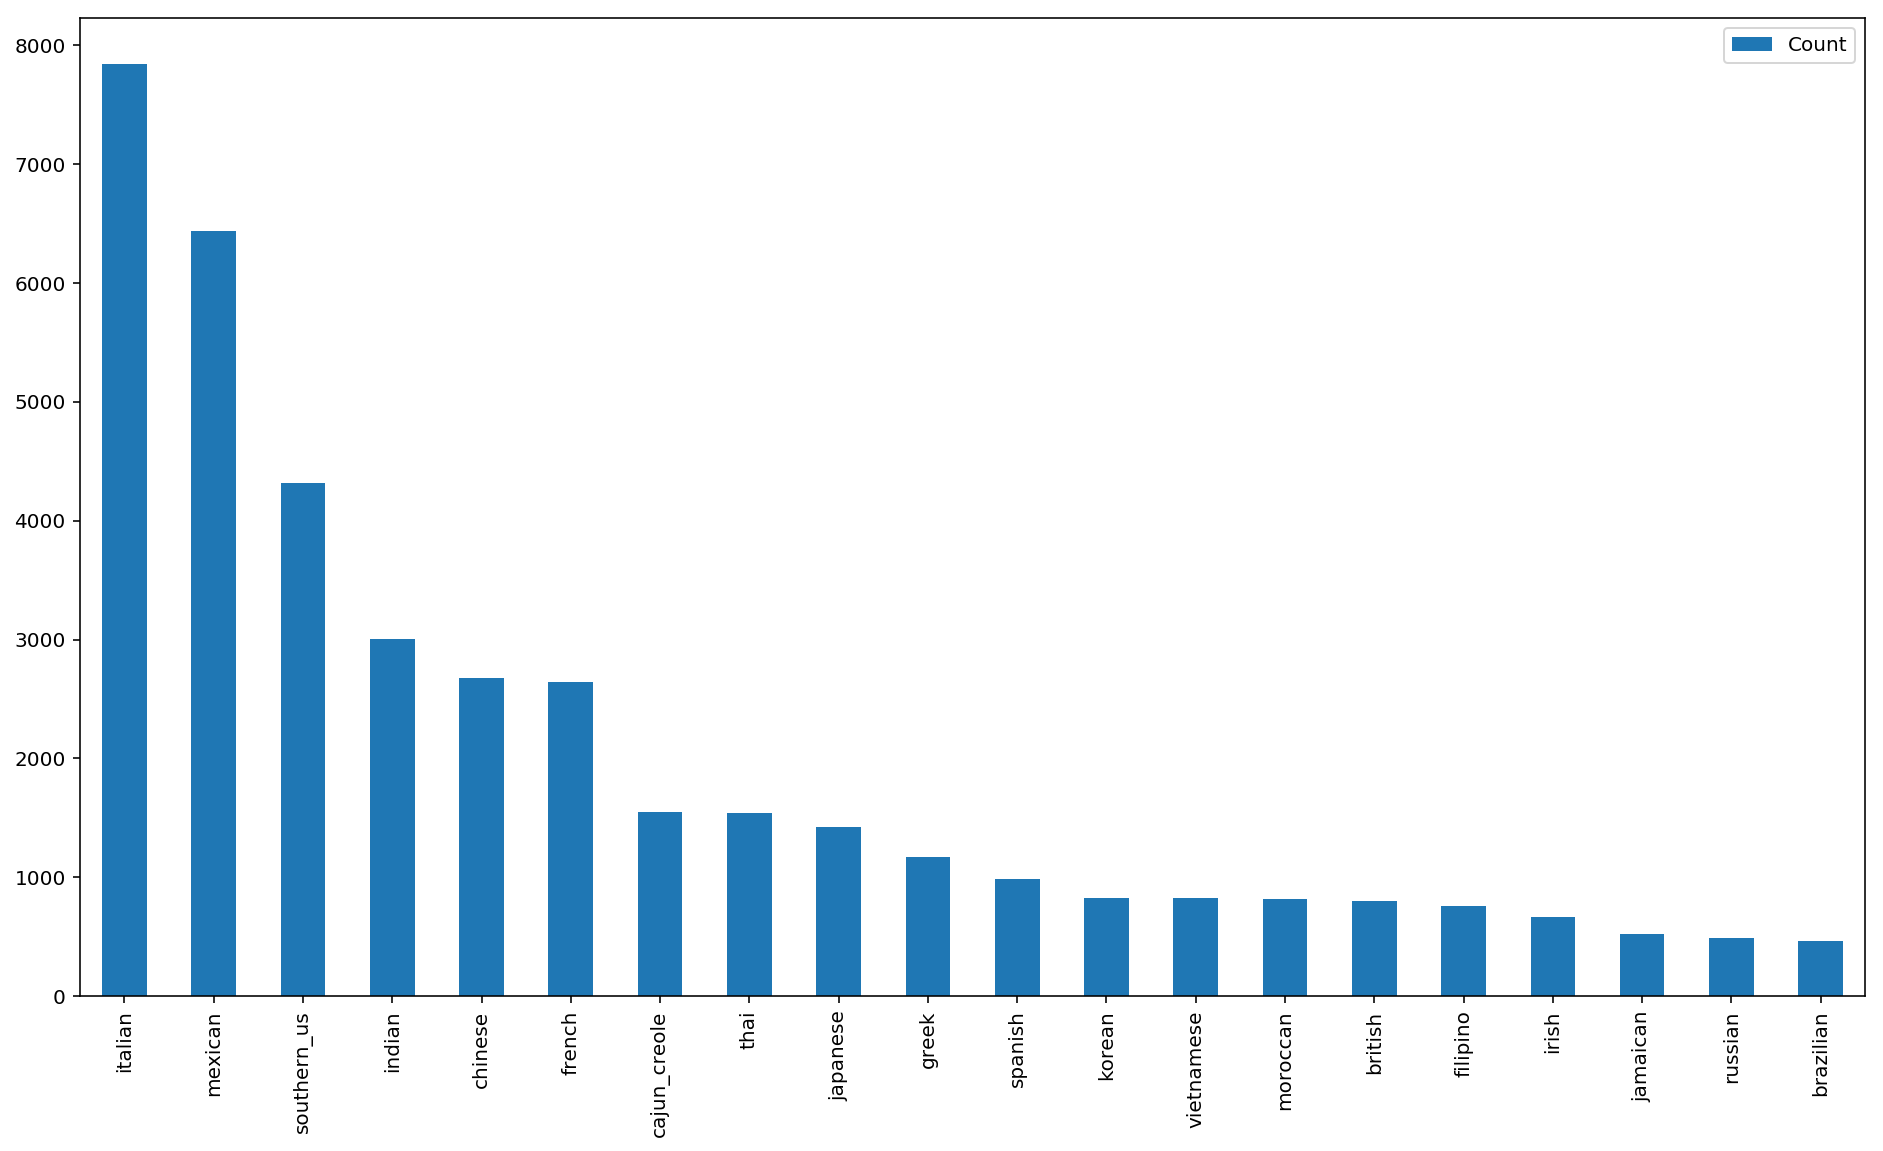

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
cuisine_df.plot(kind='bar', ax=ax)

plt.show()

We can see Italian cusine is most popular one while brazilian has least popularity.

In [9]:
# list out all ingredients
allingredients = []
for item in train['ingredients']:
    for ingr in item:
        allingredients.append(ingr)

In [10]:
from collections import Counter
count_ingr = Counter(allingredients)
# for ingr in allingredients:
#     count_ingr[ingr]
count_ingr

Counter({'romaine lettuce': 270,
         'black olives': 229,
         'grape tomatoes': 228,
         'garlic': 7380,
         'pepper': 4438,
         'purple onion': 1896,
         'seasoning': 137,
         'garbanzo beans': 148,
         'feta cheese crumbles': 358,
         'plain flour': 154,
         'ground pepper': 385,
         'salt': 18049,
         'tomatoes': 3058,
         'ground black pepper': 4785,
         'thyme': 361,
         'eggs': 3388,
         'green tomatoes': 108,
         'yellow corn meal': 341,
         'milk': 2263,
         'vegetable oil': 4385,
         'mayonaise': 781,
         'cooking oil': 483,
         'green chilies': 768,
         'grilled chicken breasts': 5,
         'garlic powder': 1442,
         'yellow onion': 1184,
         'soy sauce': 3296,
         'butter': 4848,
         'chicken livers': 65,
         'water': 7457,
         'wheat': 26,
         'black pepper': 2627,
         'shallots': 1477,
         'cornflour': 103,
       

In [11]:
# top 10 most used ingredients
count_ingr.most_common(20)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2782)]

People love salts and olive oils too. That's expenive!!!

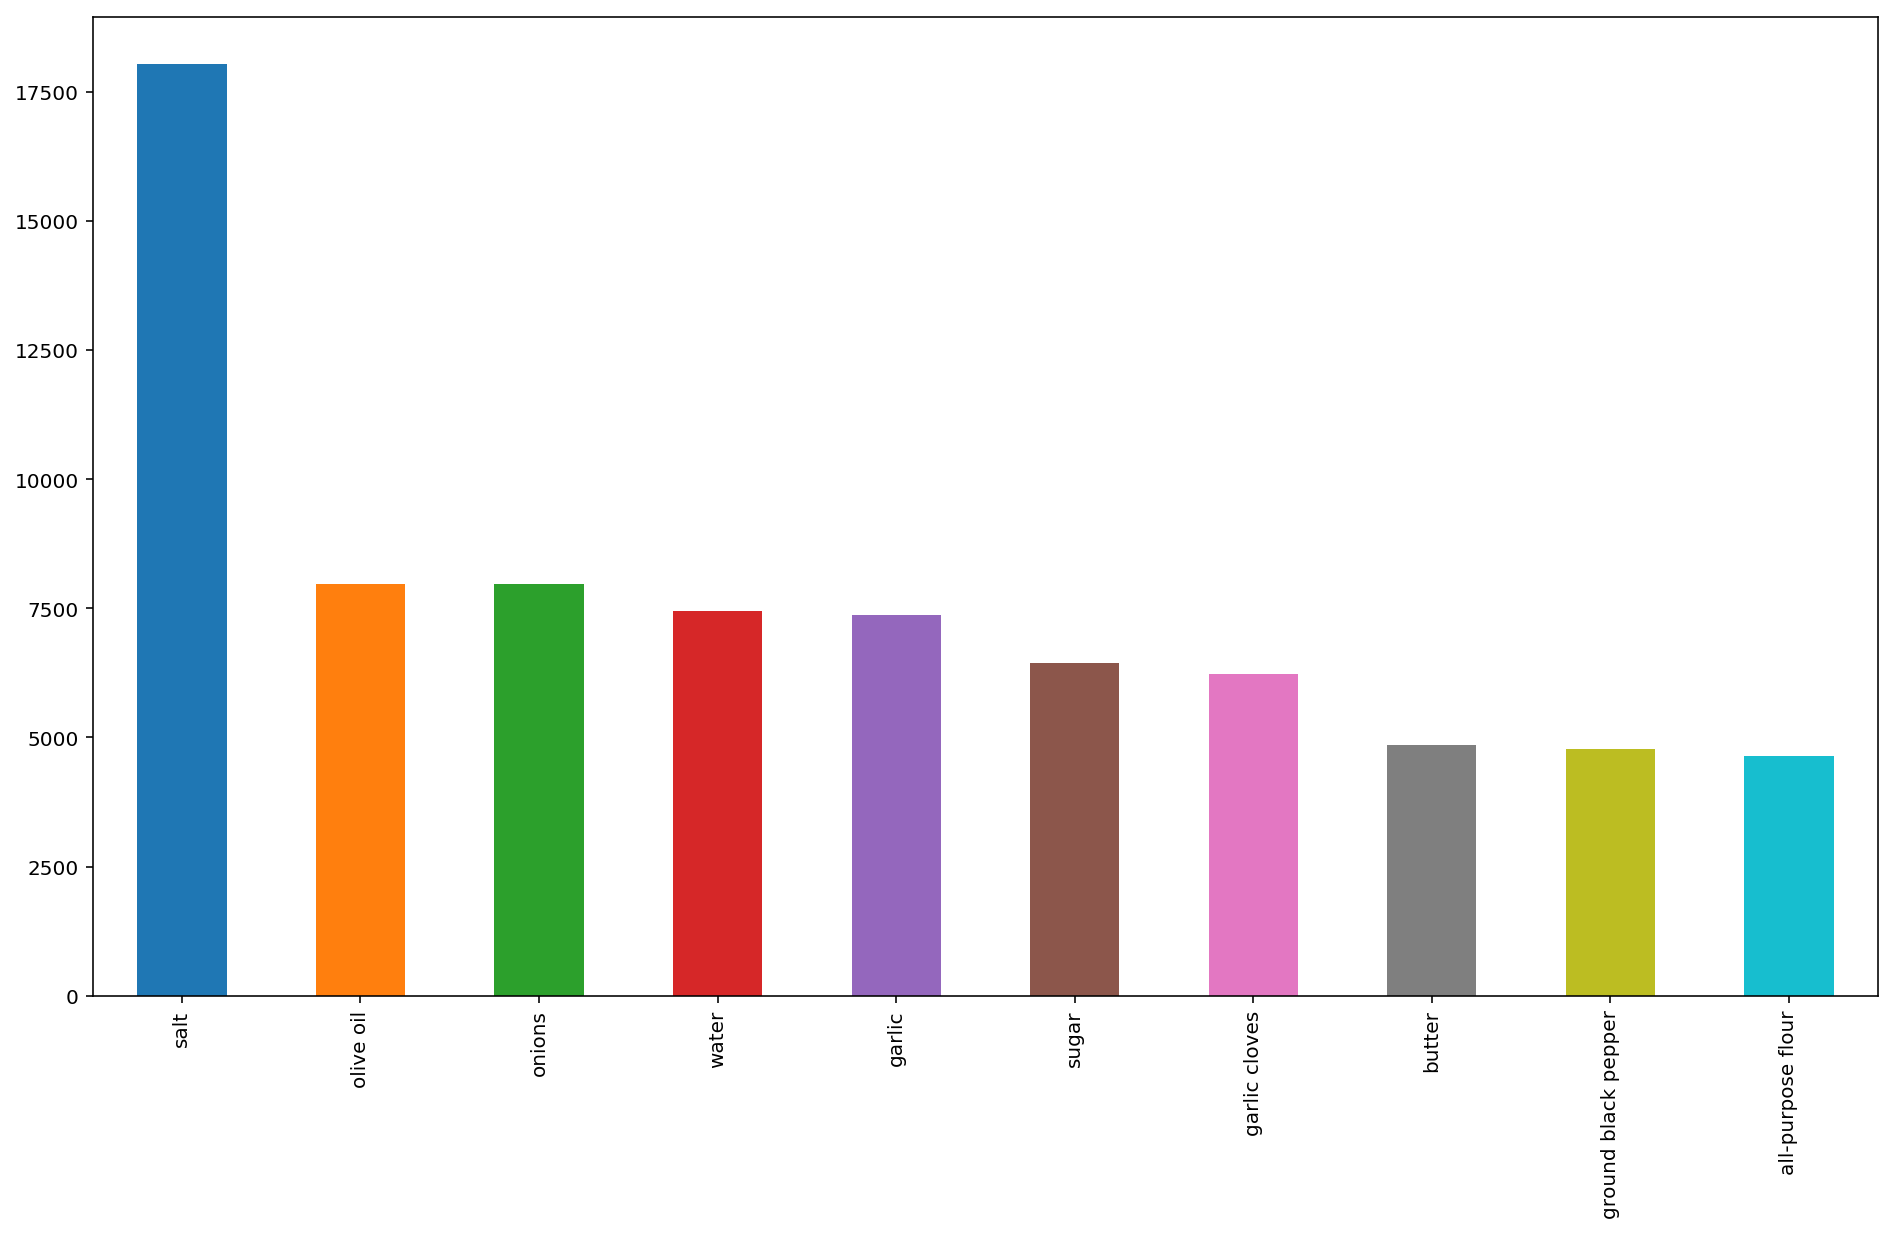

In [12]:
count_ingr = dict(count_ingr)
ingr_count = pd.Series(count_ingr)
fig, ax1 = plt.subplots(figsize=(16, 9))
ingr_count.sort_values(ascending=False)[:10].plot(kind='bar', ax=ax1)
plt.show()

# Detecting Outliers

In this case one cuisine said to be outlier if there is only one ingreidents present like one Indian cuisine having water as ingredients, well if there is water and salt there then also it can be considered as outlier but salt water could be one Indian cuisine -:p

In [13]:
train['num_ingredients'] = train['ingredients'].apply(len)
train = train[train['num_ingredients'] > 1]
train.drop('num_ingredients', axis=1, inplace=True)

In [14]:
def case_normalization(ingredients):
    ingredients = ' '.join(ingredients).lower()
    ingredients = ingredients.replace('-','')
    return ingredients

In [15]:
train['ingredients'] = train['ingredients'].apply(case_normalization)
test['ingredients']  = test['ingredients'].apply(case_normalization)
train.head()

,cuisine,id,ingredients
0,greek,10259,romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,plain flour ground pepper salt tomatoes ground...
2,filipino,20130,eggs pepper salt mayonaise cooking oil green c...
3,indian,22213,water vegetable oil wheat salt
4,indian,13162,black pepper shallots cornflour cayenne pepper...


In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
def clean_data(ingredients):
    lemmatizer = WordNetLemmatizer()
    ingredients = re.sub(r'[^\w\s\d]', '', ingredients)
    ingredients = re.sub(r'\d+', '', ingredients)
    tokens = word_tokenize(ingredients)
    words = []
    for token in tokens:
        word = lemmatizer.lemmatize(token)
        if len(word) > 0:
            words.append(word)
    return ' '.join(words)
    

In [17]:
train['features'] = train['ingredients'].apply(clean_data)
test['features'] = test['ingredients'].apply(clean_data)
train.head()

,cuisine,id,ingredients,features
0,greek,10259,romaine lettuce black olives grape tomatoes ga...,romaine lettuce black olive grape tomato garli...
1,southern_us,25693,plain flour ground pepper salt tomatoes ground...,plain flour ground pepper salt tomato ground b...
2,filipino,20130,eggs pepper salt mayonaise cooking oil green c...,egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,water vegetable oil wheat salt,water vegetable oil wheat salt
4,indian,13162,black pepper shallots cornflour cayenne pepper...,black pepper shallot cornflour cayenne pepper ...


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("functiontransform", FunctionTransformer(lambda x: x.astype('float32'), validate=False))
])

x_train = pipeline.fit_transform(train['features'].values)
x_train.sort_indices()
x_test = pipeline.transform(test['features'].values)

In [27]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['cuisine'].values)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

In [28]:
estimator = SVC(
    C = 50,
    kernel = 'rbf',
    gamma = 1.5,
    random_state=42
)
classifier = OneVsRestClassifier(estimator, n_jobs=-1)

In [29]:
classifier.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-1)

In [30]:
y_pred = label_encoder.inverse_transform(classifier.predict(x_test))
test['cuisine'] = y_pred
test[['id', 'cuisine']].to_csv('submission.csv', index=False)
test[['id', 'cuisine']].head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [31]:
!ls

__notebook_source__.ipynb  submission.csv
